## CAPSTONE PROJECT: Mapping Bycicle flux vs Bycicle Shops

##### Carlos Eduardo Bittencourt



1. Description of the problem and a discussion of the background.
2. Description of the data and how it will be used to solve the problem.
3. Data Preparation
4. Modeling
5. Evaluation


#### 1. Description of the problem and a discussion of the background.

Over the last years cycling has becoming increasingly popular as a transport method all over the world, and my city is no exception.
While it is still mainly used for recreational purposes due to city shy advance in infrastructure it just keeps growing and so are the business oportunities.
For this project I mapped the flux of bycicle traffic and contrasted with principal bike shops pointed by FourSquare. 
The goal is to show that there is plenty of room for new business, but also this map could help guide for building new bike lanes or emergency units for this specificity.

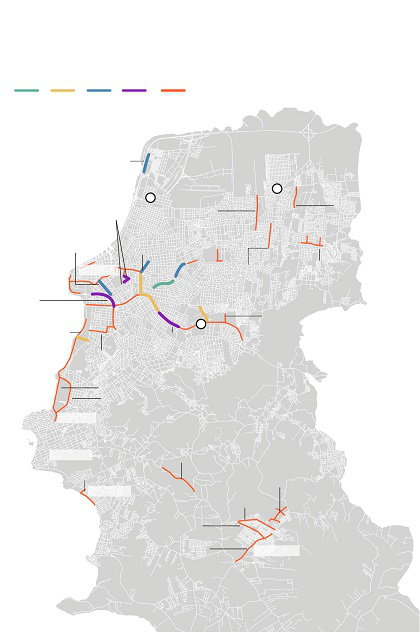

Map of current bycicle lanes in Porto Alegre


In [46]:
from IPython.display import display
from PIL import Image

path="ciclovias-Artboard_1.jpg"
display(Image.open(path))
print('Map of current bycicle lanes in Porto Alegre')

#### 2. Description of the data and how it will be used to solve the problem.

The dataset is from the city administration and it is avaliable at http://datapoa.com.br/dataset/acidentes-de-transito-acidentes in a csv file. The website is in Portuguese.
It is actually a record of many types of traffic accidents, I filtered only the ones with bycicle (more than one thousand!) and from that I did the cycling flux map.

In [4]:
# import libraries

import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
import folium # plotting library

from sklearn.cluster import KMeans
from sklearn import preprocessing


print('Libraries imported.')

Libraries imported.


#### 3. Data preparation

In [5]:
df_traff = pd.read_csv('https://dadosabertos.poa.br/dataset/d6cfbe48-ee1f-450f-87f5-9426f6a09328/resource/b56f8123-716a-4893-9348-23945f1ea1b9/download/cat_acidentes.csvData', sep=';')
df_traff.shape

(81051, 33)

In [6]:
df_traff.head()

,data_extracao,idacidente,longitude,latitude,log1,log2,predial1,tipo_acid,queda_arr,data,...,caminhao,moto,carroca,bicicleta,outro,noite_dia,regiao,cont_vit,ups,consorcio
0,2020-12-01 01:33:39,190816,NaN,NaN,R MARCOS MOREIRA,R GASTON ENGLERT,0,ABALROAMENTO,0,2020-10-17 00:00:00,...,0,1,0,0,0,NOITE,NORTE,1,5,NaN
1,2020-12-01 01:33:39,601004,-51.146812,-30.151813,R ENG OSCAR DE OLIVEIRA RAMOS,NaN,4141,ABALROAMENTO,0,2015-01-02 00:00:00,...,0,0,0,0,1,NOITE,SUL,1,5,NaN
2,2020-12-01 01:33:39,601028,-51.232759,-30.037344,NaN,NaN,0,EVENTUAL,0,2015-01-02 00:00:00,...,0,0,0,0,0,DIA,CENTRO,0,1,NaN
3,2020-12-01 01:33:39,601080,-51.214493,-30.026976,R SANTO ANTONIO,NaN,215,COLISÃO,0,2015-01-05 00:00:00,...,0,0,0,0,0,DIA,CENTRO,0,1,NaN
4,2020-12-01 01:33:39,601111,-51.185210,-30.036497,R CARAZINHO,NaN,741,ABALROAMENTO,0,2015-01-04 00:00:00,...,0,1,0,0,0,DIA,NORTE,1,5,NaN


In [7]:
df_bike = df_traff[df_traff.bicicleta != 0]
df_bike.reset_index(drop=True, inplace=True)
df_bike.head()

,data_extracao,idacidente,longitude,latitude,log1,log2,predial1,tipo_acid,queda_arr,data,...,caminhao,moto,carroca,bicicleta,outro,noite_dia,regiao,cont_vit,ups,consorcio
0,2020-12-01 01:33:39,601251,-51.227888,-30.048904,AV PRAIA DE BELAS,NaN,1181,ABALROAMENTO,0,2015-01-11 00:00:00,...,0,0,0,1,0,NOITE,CENTRO,1,5,NaN
1,2020-12-01 01:33:39,601236,-51.148988,-30.067380,AV BENTO GONCALVES,NaN,6741,ABALROAMENTO,0,2015-01-09 00:00:00,...,0,1,0,1,0,NOITE,LESTE,1,5,NaN
2,2020-12-01 01:33:39,601112,-51.256198,-30.109581,R SARGENTO NICOLAU DIAS DE FARIAS,NaN,486,ABALROAMENTO,0,2015-01-05 00:00:00,...,0,0,0,1,0,NOITE,SUL,1,5,NaN
3,2020-12-01 01:33:39,601014,-51.233611,-30.105825,R DR PEREIRA NETO,R JOAO MORA,0,ABALROAMENTO,0,2015-01-04 00:00:00,...,0,1,0,1,0,DIA,SUL,1,5,NaN
4,2020-12-01 01:33:39,601215,-51.184114,-30.113348,R VENTURA PINTO,NaN,185,ABALROAMENTO,0,2015-01-07 00:00:00,...,0,0,0,1,0,DIA,SUL,1,5,NaN


In [8]:
df_bike.columns

Index(['data_extracao', 'idacidente', 'longitude', 'latitude', 'log1', 'log2',
       'predial1', 'tipo_acid', 'queda_arr', 'data', 'dia_sem', 'hora',
       'feridos', 'feridos_gr', 'mortes', 'morte_post', 'fatais', 'auto',
       'taxi', 'lotacao', 'onibus_urb', 'onibus_met', 'onibus_int', 'caminhao',
       'moto', 'carroca', 'bicicleta', 'outro', 'noite_dia', 'regiao',
       'cont_vit', 'ups', 'consorcio'],
      dtype='object')

In [9]:
df_bike.drop(['cont_vit', 'ups', 'consorcio', 'data_extracao', 'log1', 'log2', 'predial1', 'outro', 'noite_dia',
             'queda_arr', 'data', 'dia_sem', 'hora', 'feridos', 'feridos_gr', 'mortes', 'morte_post', 'fatais', 
              'auto', 'taxi', 'lotacao', 'onibus_urb', 'onibus_met', 'onibus_int', 'caminhao','moto', 'carroca', 'tipo_acid', 'bicicleta'],
             axis=1, inplace=True)

C:\Users\ceb_p\anaconda3\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
df_bike = df_bike[df_bike['longitude'].notna()]
df_bike = df_bike[df_bike['latitude'].notna()]

In [11]:
df_bike.reset_index(drop=True, inplace=True)
df_bike.head()

,idacidente,longitude,latitude,regiao
0,601251,-51.227888,-30.048904,CENTRO
1,601236,-51.148988,-30.067380,LESTE
2,601112,-51.256198,-30.109581,SUL
3,601014,-51.233611,-30.105825,SUL
4,601215,-51.184114,-30.113348,SUL


In [12]:
#df_bike = df_bike[0:300]

In [13]:
df_bike.shape

(618, 4)

In [14]:
df_bike.reset_index(drop=True, inplace=True)

In [15]:
df_bike.rename(columns={'idacidente':'id', 'regiao':'borough'}, inplace=True)

In [16]:
df_bike.groupby('borough').count()

,id,longitude,latitude
borough,,,
CENTRO,130,130,130
LESTE,142,142,142
NORTE,167,167,167
SUL,179,179,179


In [17]:
df_bike['borough'] = df_bike['borough'].str.replace('NORTE','North')
df_bike['borough'] = df_bike['borough'].str.replace('SUL','South')
df_bike['borough'] = df_bike['borough'].str.replace('LESTE','East')
df_bike['borough'] = df_bike['borough'].str.replace('CENTRO','Centre')

In [18]:
df_bike.head()

,id,longitude,latitude,borough
0,601251,-51.227888,-30.048904,Centre
1,601236,-51.148988,-30.067380,East
2,601112,-51.256198,-30.109581,South
3,601014,-51.233611,-30.105825,South
4,601215,-51.184114,-30.113348,South


In [19]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         618 non-null    int64  
 1   longitude  618 non-null    float64
 2   latitude   618 non-null    float64
 3   borough    618 non-null    object 
dtypes: float64(2), int64(1), object(1)
memory usage: 19.4+ KB


In [20]:
address = 'Porto Alegre, RS'

geolocator = Nominatim(user_agent="poa_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

-30.0324999 -51.2303767


In [42]:
# create map of Toronto and it's neighbourhoods, then the markers
map_poa = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough in zip(df_bike['latitude'], df_bike['longitude'], df_bike['borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=0.8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_poa)  
    
map_poa

### 4. Data Modeling

In [26]:
# Foursquare Credentials

CLIENT_ID = '1Z0POCBN35HT00UZRDHULNLIQWUMOORVEOEQ4CLQW52VGBDF' # your Foursquare ID
CLIENT_SECRET = 'DCNLFUDB30CNK5LRP3RMXRVGKPTGZEVMA3QGTLI5DQKDUIVY' # your Foursquare Secret
ACCESS_TOKEN = '3IYJYOFCZTDCDNYUCTHX5MFHBG0KIDP0JVGKDBLGZQACEVQD' # your FourSquare Access Token
VERSION = '20180605'
LIMIT = 100
radius = 30500
search_query = 'bicicleta'

In [27]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=1Z0POCBN35HT00UZRDHULNLIQWUMOORVEOEQ4CLQW52VGBDF&client_secret=DCNLFUDB30CNK5LRP3RMXRVGKPTGZEVMA3QGTLI5DQKDUIVY&ll=-30.0324999,-51.2303767&oauth_token=3IYJYOFCZTDCDNYUCTHX5MFHBG0KIDP0JVGKDBLGZQACEVQD&v=20180605&query=bicicleta&radius=30500&limit=100'

In [28]:
results = requests.get(url).json()

In [29]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = pd.json_normalize(venues)
dataframe.shape

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

In [30]:
dataframe_filtered.head()

,name,categories,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,address,postalCode,crossStreet,neighborhood,id
0,Oficina Comunitária da Cidade da Bicicleta,Athletics & Sports,-30.041952,-51.225733,"[{'label': 'display', 'lat': -30.0419515810047...",1143,BR,Porto Alegre,RS,Brasil,"[Porto Alegre, RS]",NaN,NaN,NaN,NaN,5420b61f498ec006c4241743
1,Cidade da Bicicleta,Bike Shop,-30.050359,-51.218483,"[{'label': 'display', 'lat': -30.0503593093130...",2294,BR,Porto Alegre,RS,Brasil,"[R. Marcílio Dias, 1091, Porto Alegre, RS, 901...","R. Marcílio Dias, 1091",90130-001,NaN,NaN,4d65085b601d88bf237cbfbb
2,Bicicletário DEMHAB,Parking,-30.045835,-51.203398,"[{'label': 'display', 'lat': -30.0458347120733...",2993,BR,Porto Alegre,RS,Brasil,"[Av. Princesa Isabel 1115, Porto Alegre, RS]",Av. Princesa Isabel 1115,NaN,NaN,NaN,565c760a498e0ac7fd9c68e0
3,Bicicletário,Bike Shop,-30.049401,-51.227576,"[{'label': 'display', 'lat': -30.049401, 'lng'...",1900,BR,Porto Alegre,RS,Brasil,"[Av Praia De Belas, Porto Alegre, RS]",Av Praia De Belas,NaN,NaN,NaN,58ee8fab2980db13cf66ffce
4,Bicicletário do HCPA,Bike Shop,-30.039238,-51.206719,"[{'label': 'display', 'lat': -30.0392381007610...",2400,BR,NaN,NaN,Brasil,NaN,NaN,NaN,NaN,NaN,530c81cd11d28427601d5106


In [31]:
# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='purple',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(map_poa)

# display map
map_poa

### 5. Evaluation